### Empirical Example for RobustiPY (Type 5)!

##### This example is designed to show how RobustiPy can be used with multiple dependent variables. In particular, it replicates the infamously retracted [Gino et al. (2020)](https://pubmed.ncbi.nlm.nih.gov/32551743/) study. See Data Colada's wonderful blog posts about it [here](https://datacolada.org/118).

In [1]:
import os
import urllib.request
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from robustipy.models import OLSRobust
from robustipy.utils import get_colormap_colors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns

n_draws = 1000
import warnings
from robustipy.prototypes import MissingValueWarning

# Ignore all MissingValueWarning warnings from robustipy
warnings.filterwarnings(
    action="ignore",
    category=MissingValueWarning,
    module=r"robustipy\.prototypes"
)


n_draws = 1000

In [2]:
def download_and_unzip(url: str, output_dir: str) -> None:
    """
    Downloads a ZIP file from the specified URL and extracts its contents.

    Parameters:
    - url (str): The URL of the ZIP file.
    - output_dir (str): The directory where the extracted files will be placed.

    The function performs the following steps:
    1. Download the ZIP file, represented as a binary object Z.
    2. Create the output directory if it does not exist.
    3. Extract the contents of the ZIP file into output_dir.
    4. Remove the temporary ZIP file.
    """
    
    # Define a temporary filename for storing the downloaded ZIP file.
    zip_filename = "temp_download.zip"
    
    # Step 1: Download the file.
    print(f"Downloading file from {url} ...")
    try:
        urllib.request.urlretrieve(url, zip_filename)
        print("Download complete.")
    except Exception as e:
        print(f"An error occurred during download: {e}")
        return
    
    # Step 2: Ensure that the output directory exists.
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")
    else:
        print(f"Directory already exists: {output_dir}")
    
    # Step 3: Extract the ZIP file's contents.
    print(f"Extracting contents to {output_dir} ...")
    try:
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
        print("Extraction complete.")
    except zipfile.BadZipFile as e:
        print(f"Error: The downloaded file is not a valid zip file: {e}")
    except Exception as e:
        print(f"An unexpected error occurred during extraction: {e}")
    
    # Step 4: Clean up by removing the temporary ZIP file.
    try:
        os.remove(zip_filename)
        print("Temporary file removed.")
    except Exception as e:
        print(f"Warning: Could not remove the temporary file: {e}")

# Define the URL and the directory where the extracted contents will be stored.
zip_url = "https://s3.wasabisys.com/zipballs.researchbox.org/ResearchBox_3124.zip"
extraction_directory = "../data/gino_example/ResearchBox_3124_extracted"

# Execute the download and extraction process.
download_and_unzip(zip_url, extraction_directory)


Download complete.
Directory already exists: ../data/gino_example/ResearchBox_3124_extracted
Extracting contents to ../data/gino_example/ResearchBox_3124_extracted ...
Extraction complete.
Temporary file removed.


In [3]:
def figure_plotter(results_promo_published,
                   results_preven_published,
                   results_promo,
                   results_preven,
                   results_promo_published_wnet,
                   results_preven_published_wnet,
                   results_promo_wnet,
                   results_preven_wnet,
                   fig_name):

    colors = get_colormap_colors(4)
    plt.rcParams['font.family'] = 'Helvetica'
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

    df1a = results_promo_published.summary_df.sort_values('median').reset_index(drop=True)
    df1b = results_preven_published.summary_df.sort_values('median').reset_index(drop=True)
    df2a = results_promo.summary_df.sort_values('median').reset_index(drop=True)
    df2b = results_preven.summary_df.sort_values('median').reset_index(drop=True)


    df3a = results_promo_published_wnet.summary_df.sort_values('median').reset_index(drop=True)
    df3b = results_preven_published_wnet.summary_df.sort_values('median').reset_index(drop=True)
    df4a = results_promo_wnet.summary_df.sort_values('median').reset_index(drop=True)
    df4b = results_preven_wnet.summary_df.sort_values('median').reset_index(drop=True)


    ax1.plot(df1a.index, df1a['median'], label='Promotion Condition', color=colors[0])
    ax1.fill_between(df1a.index, df1a['ci_down'], df1a['ci_up'], color=colors[0], alpha=0.15)
    ax1.plot(df1b.index, df1b['median'], label='Prevention Condition', color=colors[1])
    ax1.fill_between(df1b.index, df1b['ci_down'], df1b['ci_up'], color=colors[1], alpha=0.15)
    ax1.set_xlabel('Model Rank', fontsize=16)
    ax1.set_ylabel('Reconstructed Estimate\n(with Moral Impurity)', fontsize=16)
    ax1.set_title('a.', loc='left', fontsize=18, y=1.025, x=-0.075)
    ax1.spines['bottom'].set_position(('outward', 10))
    ax1.spines['left'].set_position(('outward', 10))
    ax1.legend()
    ax1.tick_params(labelsize=12)
    ax1.set_ylim(-0.6, 0.7)
    ax1.set_xlim(0, ax1.get_xlim()[1])
    ax1.grid(True, axis='both', linestyle=(0, (2, 6)),
             linewidth=0.74, alpha=0.3, color='k', zorder=3)

    ax2.plot(df2a.index, df2a['median'], label='Promotion Condition', color=colors[0])
    ax2.fill_between(df2a.index, df2a['ci_down'], df2a['ci_up'], color=colors[0], alpha=0.15)
    ax2.plot(df2b.index, df2b['median'], label='Prevention Condition', color=colors[1])
    ax2.fill_between(df2b.index, df2b['ci_down'], df2b['ci_up'], color=colors[1], alpha=0.15)
    ax2.set_ylabel('Published Estimate\n(with Moral Impurity)', fontsize=16)
    ax2.set_xlabel('Model Rank', fontsize=16)
    ax2.legend()
    ax2.spines['bottom'].set_position(('outward', 10))
    ax2.spines['left'].set_position(('outward', 10))
    ax2.set_title('b.', loc='left', fontsize=18, y=1.025, x=-0.075)
    ax2.tick_params(labelsize=12)
    ax2.set_ylim(-0.6, 0.7)
    ax2.set_xlim(0, ax2.get_xlim()[1])
    ax2.grid(True, axis='both', linestyle=(0, (2, 6)),
             linewidth=0.74, alpha=0.3, color='k', zorder=3)

    ax3.plot(df3a.index, df3a['median'], label='Promotion Condition', color=colors[0])
    ax3.fill_between(df3a.index, df3a['ci_down'], df3a['ci_up'], color=colors[0], alpha=0.15)
    ax3.plot(df3b.index, df3b['median'], label='Prevention Condition', color=colors[1])
    ax3.fill_between(df3b.index, df3b['ci_down'], df3b['ci_up'], color=colors[1], alpha=0.15)
    ax3.set_xlabel('Model Rank', fontsize=16)
    ax3.set_ylabel('Reconstructed Estimate\n(with Networking Intentions)', fontsize=16)
    ax3.set_title('c.', loc='left', fontsize=18, y=1.025, x=-0.075)
    ax3.spines['bottom'].set_position(('outward', 10))
    ax3.spines['left'].set_position(('outward', 10))
    ax3.legend()
    ax3.tick_params(labelsize=12)
    ax3.set_ylim(-0.6, 0.7)
    ax3.set_xlim(0, ax3.get_xlim()[1])
    ax3.grid(True, axis='both', linestyle=(0, (2, 6)),
             linewidth=0.74, alpha=0.3, color='k', zorder=3)

    ax4.plot(df4a.index, df4a['median'], label='Promotion Condition', color=colors[0])
    ax4.fill_between(df4a.index, df4a['ci_down'], df4a['ci_up'], color=colors[0], alpha=0.15)
    ax4.plot(df4b.index, df4b['median'], label='Prevention Condition', color=colors[1])
    ax4.fill_between(df4b.index, df4b['ci_down'], df4b['ci_up'], color=colors[1], alpha=0.15)
    ax4.set_xlabel('Model Rank', fontsize=16)
    ax4.set_ylabel('Published Estimate\n(with Networking Intentions)', fontsize=16)
    ax4.set_title('d.', loc='left', fontsize=18, y=1.025, x=-0.075)
    ax4.spines['bottom'].set_position(('outward', 10))
    ax4.spines['left'].set_position(('outward', 10))
    ax4.legend()
    ax4.tick_params(labelsize=12)
    ax4.set_ylim(-0.6, 0.7)
    ax4.set_xlim(0, ax3.get_xlim()[1])
    ax4.grid(True, axis='both', linestyle=(0, (2, 6)),
             linewidth=0.74, alpha=0.3, color='k', zorder=3)

    legend_elements2 = [Patch(facecolor=colors[0], edgecolor='k',
                              label=r'Promotion (CI)', alpha=0.7),
                        Line2D([0], [0], color=colors[0], lw=1, linestyle='-',
                               label=r'Promotion (Med.)', alpha=0.7),
                        Patch(facecolor=colors[1], edgecolor='k',
                              label=r'Prevention (CI)', alpha=0.7),
                        Line2D([0], [0], color=colors[1], lw=1, linestyle='-',
                               label=r'Prevention (Med.)', alpha=0.7)]
    ax2.legend(handles=legend_elements2, loc='upper right', frameon=True,
               fontsize=10, framealpha=1, facecolor='w', ncols=2,
               edgecolor=(0, 0, 0, 1),
               )

    ax1.get_legend().remove()
    ax3.get_legend().remove()
    ax4.get_legend().remove()
    
    plt.tight_layout()
    sns.despine()
    os.makedirs(os.path.join('..',
                         'figures',
                         'gino_example',
                        ),
            exist_ok=True
           )
    plt.savefig("../figures/gino_example/" + fig_name + '.pdf', bbox_inches='tight')
    plt.savefig("../figures/gino_example/" + fig_name + '.png', bbox_inches='tight', dpi=400)
    plt.savefig("../figures/gino_example/" + fig_name + '.svg', bbox_inches='tight')

In [4]:
box = '../data/gino_example/ResearchBox_3124_extracted/ResearchBox 3124/'
data = pd.read_csv(box + "Data/Gino et al. (2020) Study 3A Posted Data.csv")
corrected_data = pd.read_csv(box + "Data/Data Cleaned & Re-constructed.csv")

## Comparison using moral impurity items

Output()

Calculating Composite Ys
[OLSRobust] Running with n_cpu=31, draws=1000


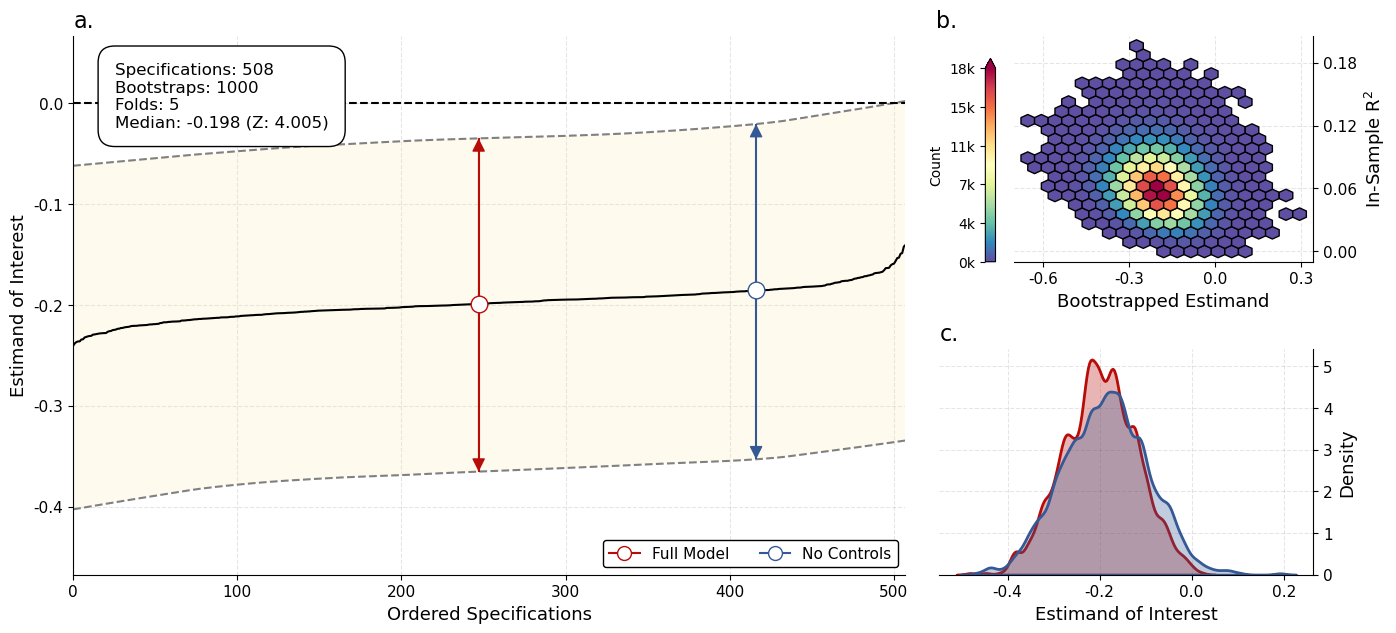

In [5]:
y = ['moralImpurity_1',
     'moralImpurity_2',
     'moralImpurity_3',
     'moralImpurity_4',
     'moralImpurity_5',
     'moralImpurity_6',
     'moralImpurity_7']
x = [
    'promotion_Dummy',
    'prevention_dummy',
    #'control_Dummy'
     ]
c= ['age',
    'male']

gino_promo_published = OLSRobust(y=y, x=x, data=data)
gino_promo_published.fit(controls=c, draws=n_draws)
gino_results_promo_published = gino_promo_published.get_results()
gino_results_promo_published.plot(ic='hqic',
                                  ext='pdf',
                                  ci=0.95,
                                  loess=True,
                                  project_name='gino_results_promo_published',
                                  figpath = '../figures',
                                  figsize=(16, 7)
                                 )

In [6]:
gino_results_promo_published.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: [('moralImpurity_1',), ('moralImpurity_1',), ('moralImpurity_1',), ('moralImpurity_1',), ('moralImpurity_2',), ('moralImpurity_2',), ('moralImpurity_2',), ('moralImpurity_2',), ('moralImpurity_3',), ('moralImpurity_3',), ('moralImpurity_3',), ('moralImpurity_3',), ('moralImpurity_4',), ('moralImpurity_4',), ('moralImpurity_4',), ('moralImpurity_4',), ('moralImpurity_5',), ('moralImpurity_5',), ('moralImpurity_5',), ('moralImpurity_5',), ('moralImpurity_6',), ('moralImpurity_6',), ('moralImpurity_6',), ('moralImpurity_6',), ('moralImpurity_7',), ('moralImpurity_7',), ('moralImpurity_7',), ('moralImpurity_7',), ('moralImpurity_1', 'moralImpurity_2'), ('moralImpurity_1', 'moralImpurity_2'), ('moralImpurity_1', 'moralImpurity_2'), ('moralImpurity_1', 'moralImpurity_2'), ('moralImpurity_1', 'moralImpurity_3'), ('moralImpurity_1', 'moralImpurity_3'), ('moralImpurity_1', 'moralImpurity_3'), ('moralImpurity_1', 'moralI

Output()

Calculating Composite Ys
[OLSRobust] Running with n_cpu=31, draws=1000


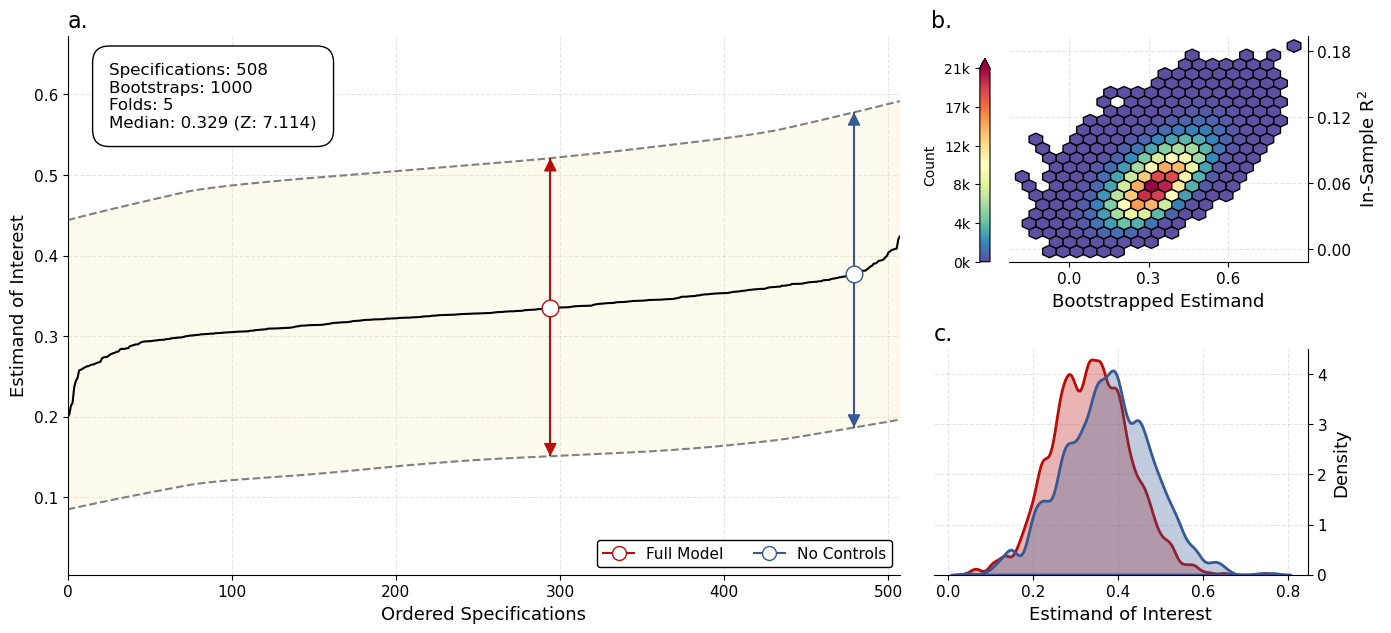

In [7]:
y = ['moralImpurity_1',
     'moralImpurity_2',
     'moralImpurity_3',
     'moralImpurity_4',
     'moralImpurity_5',
     'moralImpurity_6',
     'moralImpurity_7']
x = [
    'prevention_dummy',
    'promotion_Dummy',
    #'control_Dummy'
     ]
c= ['age',
    'male']

gino_preven_published = OLSRobust(y=y, x=x, data=data)
gino_preven_published.fit(controls=c, draws=n_draws)
gino_results_preven_published = gino_preven_published.get_results()
gino_results_preven_published.plot(ic='hqic',
                                   ext='pdf',
                                   ci=0.95,
                                   loess=True,
                                   project_name='gino_results_preven_published',
                                   figpath = '../figures',
                                   figsize=(16, 7)
                                  )

In [8]:
gino_results_preven_published.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: [('moralImpurity_1',), ('moralImpurity_1',), ('moralImpurity_1',), ('moralImpurity_1',), ('moralImpurity_2',), ('moralImpurity_2',), ('moralImpurity_2',), ('moralImpurity_2',), ('moralImpurity_3',), ('moralImpurity_3',), ('moralImpurity_3',), ('moralImpurity_3',), ('moralImpurity_4',), ('moralImpurity_4',), ('moralImpurity_4',), ('moralImpurity_4',), ('moralImpurity_5',), ('moralImpurity_5',), ('moralImpurity_5',), ('moralImpurity_5',), ('moralImpurity_6',), ('moralImpurity_6',), ('moralImpurity_6',), ('moralImpurity_6',), ('moralImpurity_7',), ('moralImpurity_7',), ('moralImpurity_7',), ('moralImpurity_7',), ('moralImpurity_1', 'moralImpurity_2'), ('moralImpurity_1', 'moralImpurity_2'), ('moralImpurity_1', 'moralImpurity_2'), ('moralImpurity_1', 'moralImpurity_2'), ('moralImpurity_1', 'moralImpurity_3'), ('moralImpurity_1', 'moralImpurity_3'), ('moralImpurity_1', 'moralImpurity_3'), ('moralImpurity_1', 'moralI

Output()

Calculating Composite Ys
[OLSRobust] Running with n_cpu=31, draws=1000


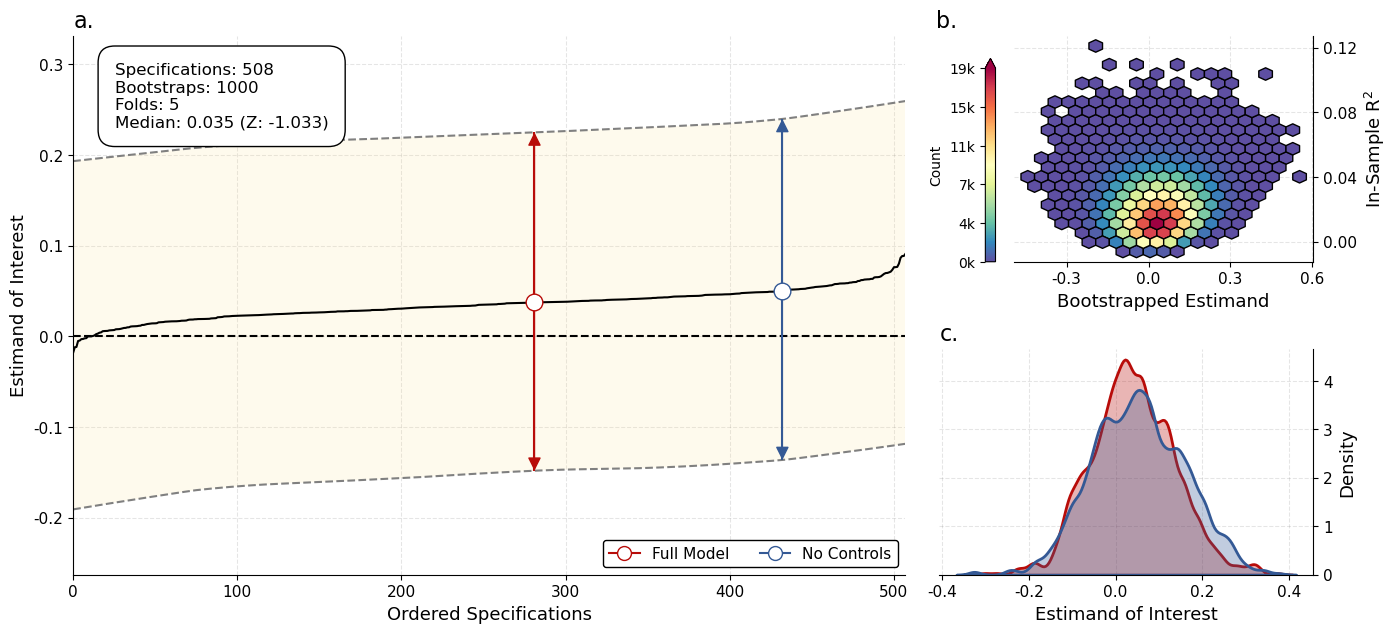

In [9]:
y = ['dirty_orig',
     'tainted_orig',
     'inauthentic_orig',
     'ashamed_orig',
     'wrong_orig',
     'unnatural_orig',
     'impure_orig']
x = [
    'promotion_Dummy',
    'prevention_dummy',
    #'control_Dummy'
     ]
c= ['age',
    'male']

gino_promo = OLSRobust(y=y, x=x, data=corrected_data)
gino_promo.fit(controls=c, draws=n_draws)
gino_results_promo = gino_promo.get_results()
gino_results_promo.plot(ic='hqic',
                        ext='pdf',
                        ci=0.95,
                        loess=True,
                        project_name='gino_results_promo',
                        figpath = '../figures',
                        figsize=(16, 7)
                       )

In [10]:
gino_results_promo.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: [('dirty_orig',), ('dirty_orig',), ('dirty_orig',), ('dirty_orig',), ('tainted_orig',), ('tainted_orig',), ('tainted_orig',), ('tainted_orig',), ('inauthentic_orig',), ('inauthentic_orig',), ('inauthentic_orig',), ('inauthentic_orig',), ('ashamed_orig',), ('ashamed_orig',), ('ashamed_orig',), ('ashamed_orig',), ('wrong_orig',), ('wrong_orig',), ('wrong_orig',), ('wrong_orig',), ('unnatural_orig',), ('unnatural_orig',), ('unnatural_orig',), ('unnatural_orig',), ('impure_orig',), ('impure_orig',), ('impure_orig',), ('impure_orig',), ('dirty_orig', 'tainted_orig'), ('dirty_orig', 'tainted_orig'), ('dirty_orig', 'tainted_orig'), ('dirty_orig', 'tainted_orig'), ('dirty_orig', 'inauthentic_orig'), ('dirty_orig', 'inauthentic_orig'), ('dirty_orig', 'inauthentic_orig'), ('dirty_orig', 'inauthentic_orig'), ('dirty_orig', 'ashamed_orig'), ('dirty_orig', 'ashamed_orig'), ('dirty_orig', 'ashamed_orig'), ('dirty_orig', 'ash

Output()

Calculating Composite Ys
[OLSRobust] Running with n_cpu=31, draws=1000


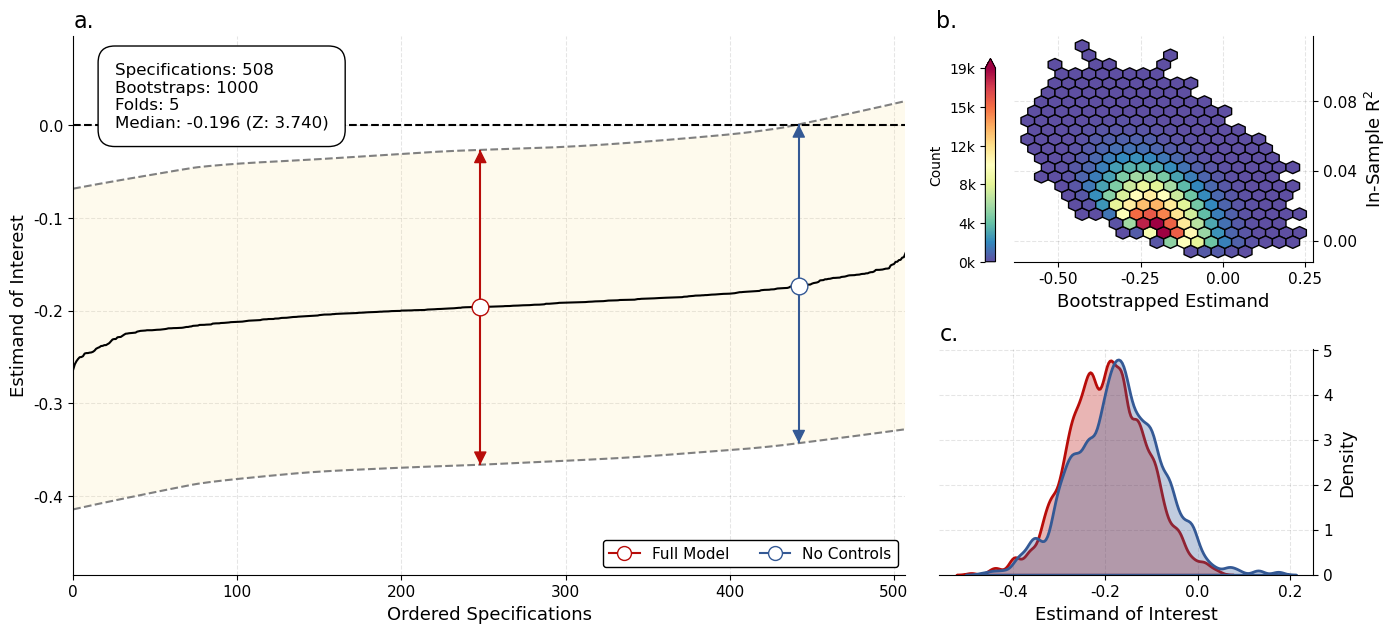

In [11]:
y = ['dirty_orig',
     'tainted_orig',
     'inauthentic_orig',
     'ashamed_orig',
     'wrong_orig',
     'unnatural_orig',
     'impure_orig']
x = [
    'prevention_dummy',
    'promotion_Dummy',
    #'control_Dummy'
    ]
c= ['age',
    'male']

gino_preven = OLSRobust(y=y, x=x, data=corrected_data)
gino_preven.fit(controls=c, draws=n_draws)
gino_results_preven = gino_preven.get_results()
gino_results_preven.plot(ic='hqic',
                         ext='pdf',
                         ci=0.95,
                         loess=True,
                         project_name='gino_results_preven',
                         figpath = '../figures',
                         figsize=(16, 7)
                        )

In [12]:
gino_results_preven.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: [('dirty_orig',), ('dirty_orig',), ('dirty_orig',), ('dirty_orig',), ('tainted_orig',), ('tainted_orig',), ('tainted_orig',), ('tainted_orig',), ('inauthentic_orig',), ('inauthentic_orig',), ('inauthentic_orig',), ('inauthentic_orig',), ('ashamed_orig',), ('ashamed_orig',), ('ashamed_orig',), ('ashamed_orig',), ('wrong_orig',), ('wrong_orig',), ('wrong_orig',), ('wrong_orig',), ('unnatural_orig',), ('unnatural_orig',), ('unnatural_orig',), ('unnatural_orig',), ('impure_orig',), ('impure_orig',), ('impure_orig',), ('impure_orig',), ('dirty_orig', 'tainted_orig'), ('dirty_orig', 'tainted_orig'), ('dirty_orig', 'tainted_orig'), ('dirty_orig', 'tainted_orig'), ('dirty_orig', 'inauthentic_orig'), ('dirty_orig', 'inauthentic_orig'), ('dirty_orig', 'inauthentic_orig'), ('dirty_orig', 'inauthentic_orig'), ('dirty_orig', 'ashamed_orig'), ('dirty_orig', 'ashamed_orig'), ('dirty_orig', 'ashamed_orig'), ('dirty_orig', 'ash

## Comparison Using Networking Intention Items

Output()

Calculating Composite Ys
[OLSRobust] Running with n_cpu=31, draws=1000


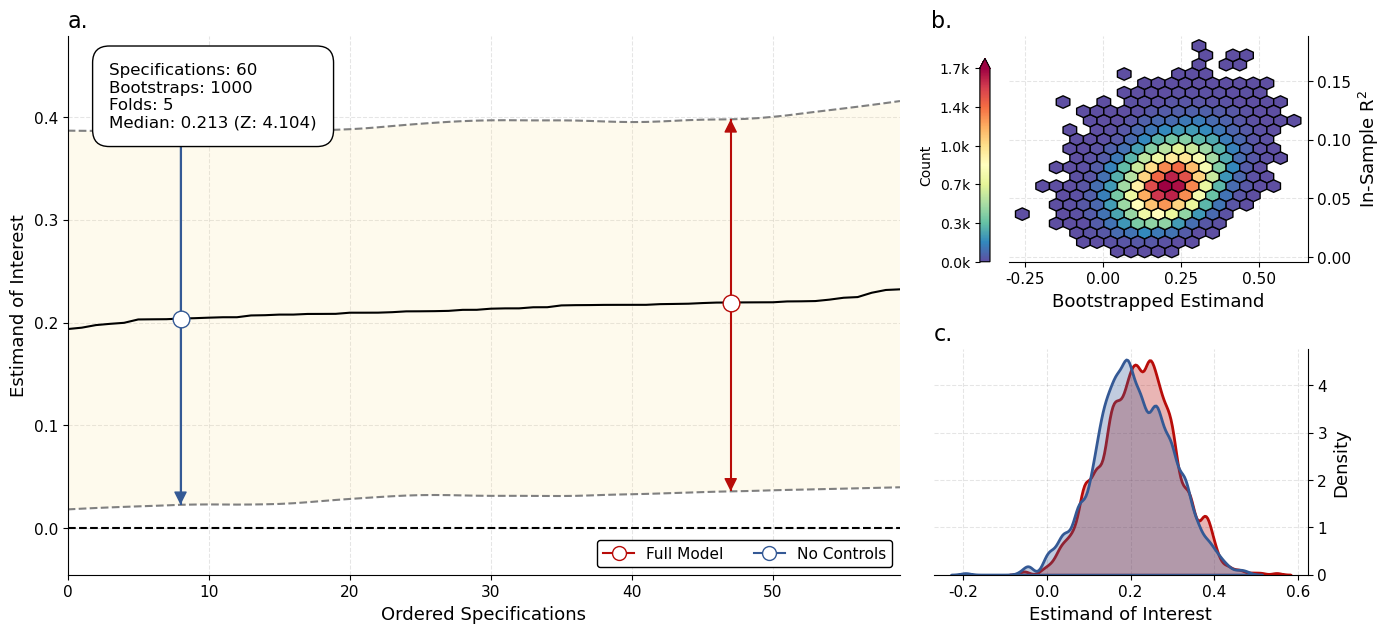

In [13]:
y = ['netIntentions_1',
     'netIntentions_2',
     'netIntentions_3',
     'netIntentions_4']
x = [
    'promotion_Dummy',
    'prevention_dummy',
    #'control_Dummy'
     ]
c= ['age',
    'male']

gino_promo_published_wnet = OLSRobust(y=y, x=x, data=data)
gino_promo_published_wnet.fit(controls=c, draws=n_draws)
gino_results_promo_published_wnet = gino_promo_published_wnet.get_results()
gino_results_promo_published_wnet.plot(ic='hqic',
                                       ext='pdf',
                                       ci=0.95,
                                       loess=True,
                                       project_name='gino_results_promo_published_wnet',
                                       figpath = '../figures',
                                       figsize=(16, 7)
                                      )

In [14]:
gino_results_promo_published_wnet.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: [('netIntentions_1',), ('netIntentions_1',), ('netIntentions_1',), ('netIntentions_1',), ('netIntentions_2',), ('netIntentions_2',), ('netIntentions_2',), ('netIntentions_2',), ('netIntentions_3',), ('netIntentions_3',), ('netIntentions_3',), ('netIntentions_3',), ('netIntentions_4',), ('netIntentions_4',), ('netIntentions_4',), ('netIntentions_4',), ('netIntentions_1', 'netIntentions_2'), ('netIntentions_1', 'netIntentions_2'), ('netIntentions_1', 'netIntentions_2'), ('netIntentions_1', 'netIntentions_2'), ('netIntentions_1', 'netIntentions_3'), ('netIntentions_1', 'netIntentions_3'), ('netIntentions_1', 'netIntentions_3'), ('netIntentions_1', 'netIntentions_3'), ('netIntentions_1', 'netIntentions_4'), ('netIntentions_1', 'netIntentions_4'), ('netIntentions_1', 'netIntentions_4'), ('netIntentions_1', 'netIntentions_4'), ('netIntentions_2', 'netIntentions_3'), ('netIntentions_2', 'netIntentions_3'), ('netIntent

Output()

Calculating Composite Ys
[OLSRobust] Running with n_cpu=31, draws=1000


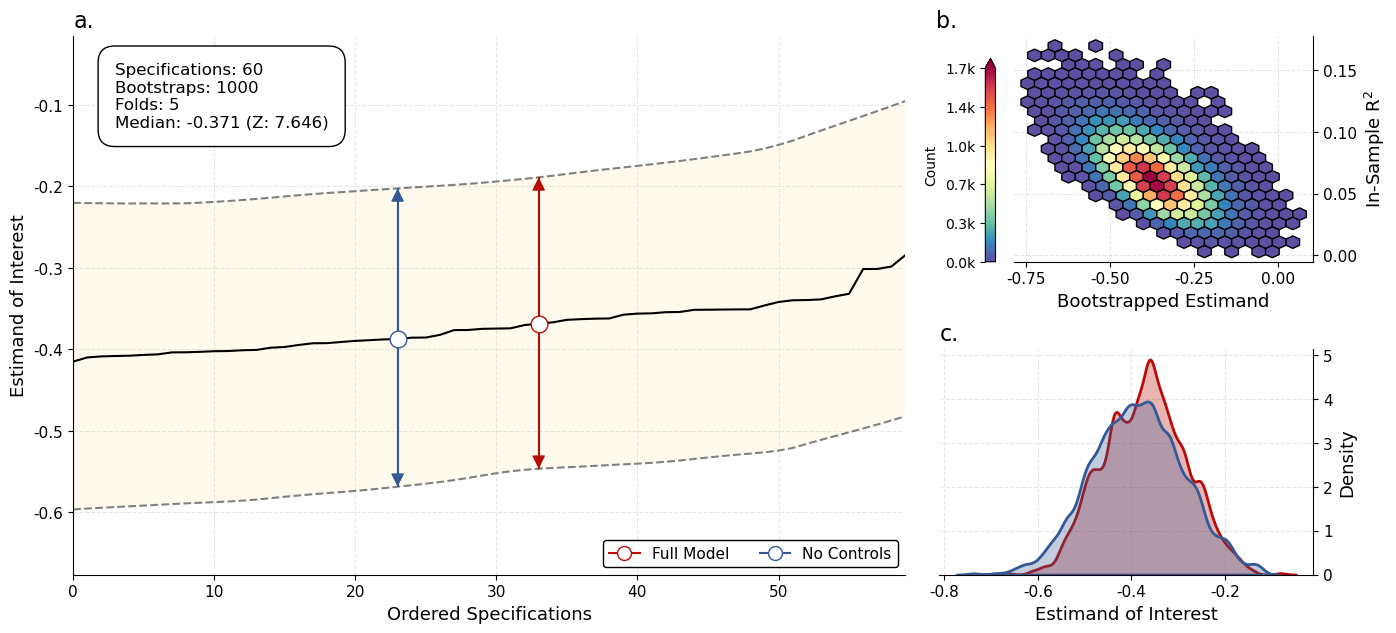

In [15]:
y = ['netIntentions_1',
     'netIntentions_2',
     'netIntentions_3',
     'netIntentions_4']
x = [
    'prevention_dummy',
    'promotion_Dummy',
    #'control_Dummy'
     ]
c= ['age',
    'male']

gino_preven_published_wnet = OLSRobust(y=y, x=x, data=data)
gino_preven_published_wnet.fit(controls=c, draws=n_draws)
gino_results_preven_published_wnet = gino_preven_published_wnet.get_results()
gino_results_preven_published_wnet.plot(ic='hqic',
                                        ext='pdf',
                                        ci=0.95,
                                        loess=True,
                                        project_name='gino_results_preven_published_wnet',
                                        figpath = '../figures',
                                        figsize=(16, 7)
                                       )

In [16]:
gino_results_preven_published_wnet.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: [('netIntentions_1',), ('netIntentions_1',), ('netIntentions_1',), ('netIntentions_1',), ('netIntentions_2',), ('netIntentions_2',), ('netIntentions_2',), ('netIntentions_2',), ('netIntentions_3',), ('netIntentions_3',), ('netIntentions_3',), ('netIntentions_3',), ('netIntentions_4',), ('netIntentions_4',), ('netIntentions_4',), ('netIntentions_4',), ('netIntentions_1', 'netIntentions_2'), ('netIntentions_1', 'netIntentions_2'), ('netIntentions_1', 'netIntentions_2'), ('netIntentions_1', 'netIntentions_2'), ('netIntentions_1', 'netIntentions_3'), ('netIntentions_1', 'netIntentions_3'), ('netIntentions_1', 'netIntentions_3'), ('netIntentions_1', 'netIntentions_3'), ('netIntentions_1', 'netIntentions_4'), ('netIntentions_1', 'netIntentions_4'), ('netIntentions_1', 'netIntentions_4'), ('netIntentions_1', 'netIntentions_4'), ('netIntentions_2', 'netIntentions_3'), ('netIntentions_2', 'netIntentions_3'), ('netIntent

Output()

Calculating Composite Ys
[OLSRobust] Running with n_cpu=31, draws=1000


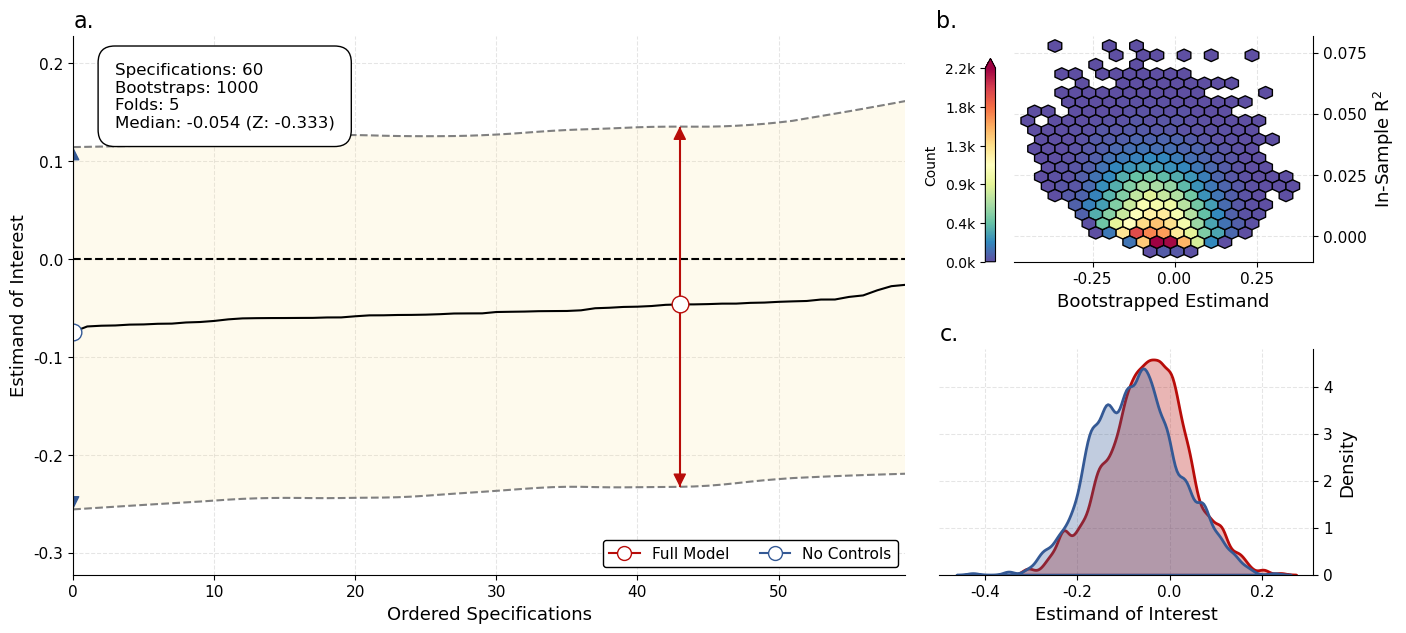

In [17]:
y = ['net_intent1_orig',
     'net_intent2_orig',
     'net_intent3_orig',
     'net_intent4_orig']
x = [
    'promotion_Dummy',
    'prevention_dummy',
    #'control_Dummy'
     ]
c= ['age',
    'male']

gino_promo_wnet = OLSRobust(y=y, x=x, data=corrected_data)
gino_promo_wnet.fit(controls=c, draws=n_draws)
gino_results_promo_wnet = gino_promo_wnet.get_results()
gino_results_promo_wnet.plot(ic='hqic',
                             ext='pdf',
                             ci=0.95,
                             loess=True,
                             project_name='gino_results_promo_wnet',
                             figpath = '../figures',
                             figsize=(16, 7)
                            )

In [18]:
gino_results_promo_wnet.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: [('net_intent1_orig',), ('net_intent1_orig',), ('net_intent1_orig',), ('net_intent1_orig',), ('net_intent2_orig',), ('net_intent2_orig',), ('net_intent2_orig',), ('net_intent2_orig',), ('net_intent3_orig',), ('net_intent3_orig',), ('net_intent3_orig',), ('net_intent3_orig',), ('net_intent4_orig',), ('net_intent4_orig',), ('net_intent4_orig',), ('net_intent4_orig',), ('net_intent1_orig', 'net_intent2_orig'), ('net_intent1_orig', 'net_intent2_orig'), ('net_intent1_orig', 'net_intent2_orig'), ('net_intent1_orig', 'net_intent2_orig'), ('net_intent1_orig', 'net_intent3_orig'), ('net_intent1_orig', 'net_intent3_orig'), ('net_intent1_orig', 'net_intent3_orig'), ('net_intent1_orig', 'net_intent3_orig'), ('net_intent1_orig', 'net_intent4_orig'), ('net_intent1_orig', 'net_intent4_orig'), ('net_intent1_orig', 'net_intent4_orig'), ('net_intent1_orig', 'net_intent4_orig'), ('net_intent2_orig', 'net_intent3_orig'), ('net_int

Output()

Calculating Composite Ys
[OLSRobust] Running with n_cpu=31, draws=1000


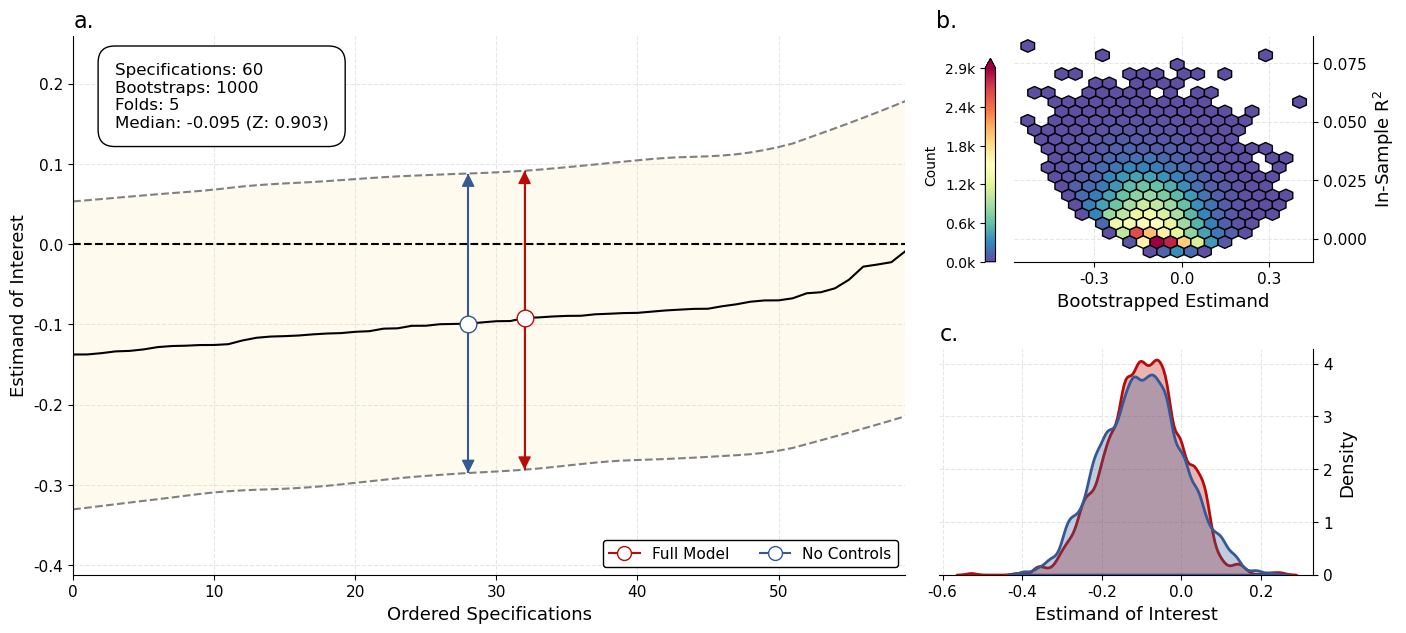

In [19]:
y = ['net_intent1_orig',
     'net_intent2_orig',
     'net_intent3_orig',
     'net_intent4_orig']
x = [
    'prevention_dummy',
    'promotion_Dummy',
    #'control_Dummy'
     ]
c= ['age',
    'male']

gino_preven_wnet = OLSRobust(y=y, x=x, data=corrected_data)
gino_preven_wnet.fit(controls=c, draws=n_draws)
gino_results_preven_wnet = gino_preven_wnet.get_results()
gino_results_preven_wnet.plot(ic='hqic',
                              ext='pdf',
                              ci=0.95,
                              loess=True,
                              project_name='gino_results_preven_wnet',
                              figpath = '../figures',
                              figsize=(16, 7)
                             )

In [20]:
gino_results_preven_wnet.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: [('net_intent1_orig',), ('net_intent1_orig',), ('net_intent1_orig',), ('net_intent1_orig',), ('net_intent2_orig',), ('net_intent2_orig',), ('net_intent2_orig',), ('net_intent2_orig',), ('net_intent3_orig',), ('net_intent3_orig',), ('net_intent3_orig',), ('net_intent3_orig',), ('net_intent4_orig',), ('net_intent4_orig',), ('net_intent4_orig',), ('net_intent4_orig',), ('net_intent1_orig', 'net_intent2_orig'), ('net_intent1_orig', 'net_intent2_orig'), ('net_intent1_orig', 'net_intent2_orig'), ('net_intent1_orig', 'net_intent2_orig'), ('net_intent1_orig', 'net_intent3_orig'), ('net_intent1_orig', 'net_intent3_orig'), ('net_intent1_orig', 'net_intent3_orig'), ('net_intent1_orig', 'net_intent3_orig'), ('net_intent1_orig', 'net_intent4_orig'), ('net_intent1_orig', 'net_intent4_orig'), ('net_intent1_orig', 'net_intent4_orig'), ('net_intent1_orig', 'net_intent4_orig'), ('net_intent2_orig', 'net_intent3_orig'), ('net_int

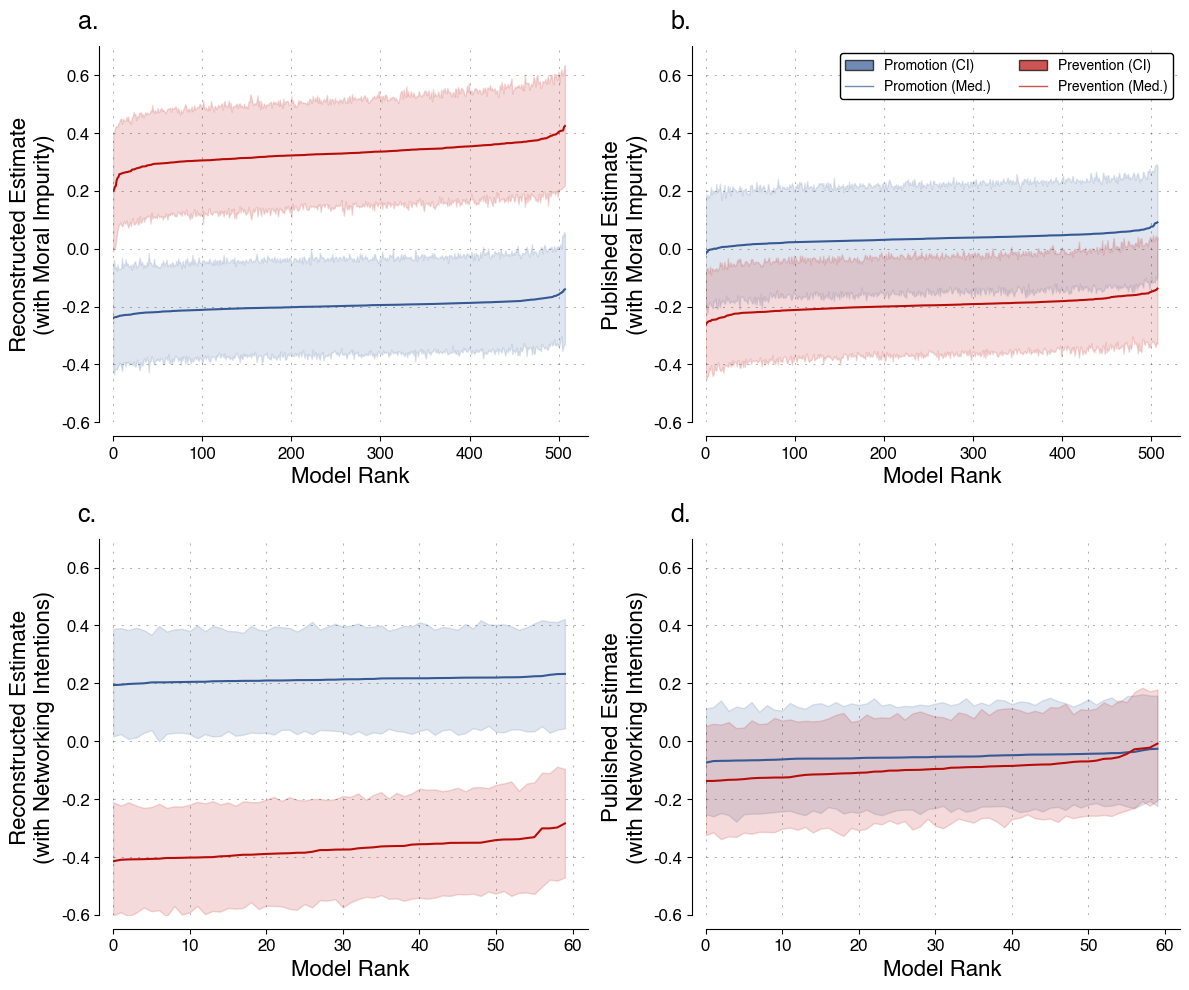

In [22]:
figure_plotter(gino_results_promo_published,
               gino_results_preven_published,
               gino_results_promo,
               gino_results_preven,
               gino_results_promo_published_wnet,
               gino_results_preven_published_wnet,
               gino_results_promo_wnet,
               gino_results_preven_wnet,
               'gino_figure')